## Loading the libraries

In [1]:
import os
import time
from datetime import datetime

# === Data Handling ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scikit-learn (Modeling & Evaluation) ===
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

# === Saving & Loading Models ===
from joblib import dump, load

## Exploring the dataset

In [2]:
# Load the dataset
file_path = "/Volumes/Repository/Metaperception/Study 1/Datasets/Part 1/complete_dataset_with_sentiment.csv"
df = pd.read_csv(file_path)

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

# Display the first 5 rows
print("\nFirst 5 rows:")
print(df.head())

/var/folders/jr/dg0v0hv96x3_gj0zwfrb19nw0000gn/T/ipykernel_4121/3607108366.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Dataset shape: (10976231, 15)

Column names:
['full_text', 'conversation_id_str', 'created_at', 'id_str', 'user', 'prolife_prochoice', 'source', 'binary_morality', 'care', 'purity', 'loyalty', 'authority', 'fairness', 'sentiment_score', 'sentiment_label']

First 5 rows:
                                           full_text  conversation_id_str  \
0  Happy #prochoice New Year. #HumanRights for wo...         5.504415e+17   
1  Hands That Shed Innocent Blood\nhttp://t.co/wq...         5.504448e+17   
2  Tx St Rep Trey Martinez Fischer voted for the ...         5.504474e+17   
3  Calvary Chapel Pastor supports @PersonhoodFL F...         5.504482e+17   
4  Black Sheriff Says if Black Lives Mattered The...         5.504492e+17   

                       created_at                id_str  \
0  Thu Jan 01 00:01:02 +0000 2015  550441533166456832.0   
1  Thu Jan 01 00:13:56 +0000 2015  550444775959035904.0   
2  Thu Jan 01 00:24:10 +0000 2015  550447352910078016.0   
3  Thu Jan 01 00:27:40 +0000 2

## Temporal Distribution of Tweets

Number of dates that failed to parse: 803 (0.01%)

Date Range Analysis:
Earliest tweet: 2015-01-01 00:01:02+00:00
Latest tweet: 2023-01-06 00:44:22+00:00
Total time span: 2927 days

Tweets per year:
2015.0: 614,755 tweets (5.60%)
2016.0: 391,122 tweets (3.56%)
2017.0: 416,312 tweets (3.79%)
2018.0: 399,078 tweets (3.64%)
2019.0: 561,406 tweets (5.11%)
2020.0: 309,533 tweets (2.82%)
2022.0: 8,115,928 tweets (73.94%)
2023.0: 167,294 tweets (1.52%)

Sample of date formats in the dataset:
- 2022-08-23 10:54:11+00:00
- 2022-08-01 07:18:34+00:00
- 2022-05-05 13:15:24+00:00
- Mon Sep 10 15:53:11 +0000 2018
- Sun Jun 21 00:32:29 +0000 2015


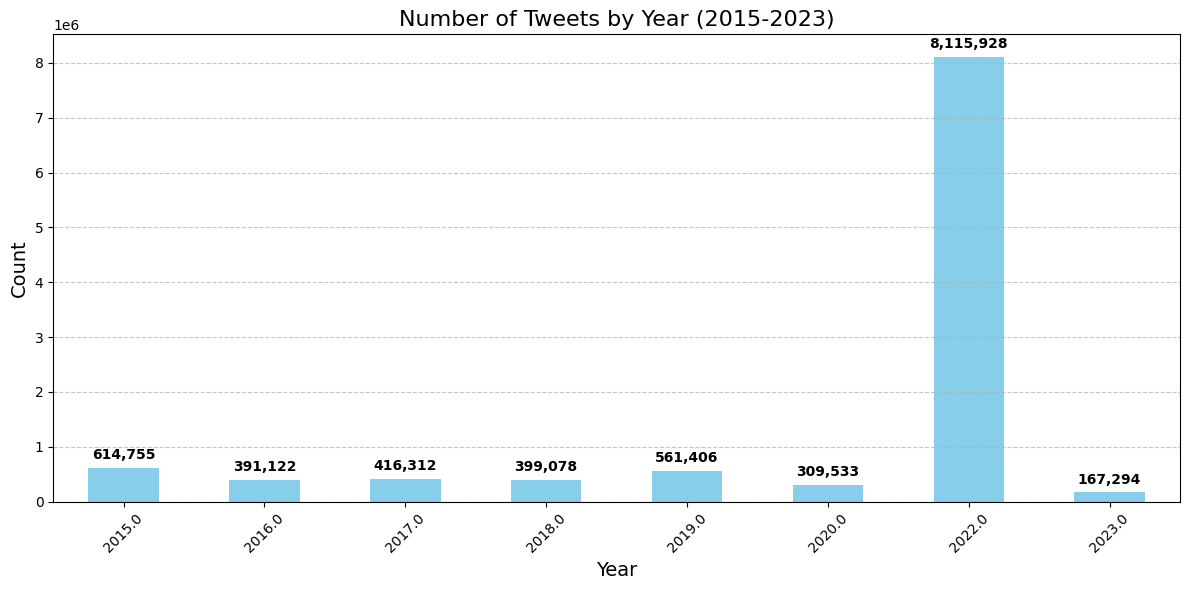

In [3]:
# Convert the 'created_at' column to datetime format with mixed format support
df['created_at_dt'] = pd.to_datetime(df['created_at'], format='mixed', errors='coerce')

# Check for any NaT (Not a Time) values that failed to parse
nat_count = df['created_at_dt'].isna().sum()
print(f"Number of dates that failed to parse: {nat_count} ({nat_count/len(df)*100:.2f}%)")

# Extract year from the datetime
df['year'] = df['created_at_dt'].dt.year

# Find earliest and latest dates
earliest_date = df['created_at_dt'].min()
latest_date = df['created_at_dt'].max()

print(f"\nDate Range Analysis:")
print(f"Earliest tweet: {earliest_date}")
print(f"Latest tweet: {latest_date}")
print(f"Total time span: {(latest_date - earliest_date).days} days")

# Count tweets by year
yearly_counts = df['year'].value_counts().sort_index()
print("\nTweets per year:")
for year, count in yearly_counts.items():
    print(f"{year}: {count:,} tweets ({count/len(df)*100:.2f}%)")

# Examine a few examples of different date formats in the dataset
print("\nSample of date formats in the dataset:")
sample_dates = df['created_at'].sample(5).tolist()
for date in sample_dates:
    print(f"- {date}")

# Create a bar chart of tweets by year
plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Tweets by Year (2015-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(yearly_counts):
    plt.text(i, count + (yearly_counts.max() * 0.02), f"{count:,}", 
             ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## Distribution of the Abortion Stance 

Number of unique values in 'prolife_prochoice' column: 4

Unique values and their frequencies:
'choice': 4,308,510 tweets (39.25%)
'throw_out': 3,015,071 tweets (27.47%)
'life': 2,155,755 tweets (19.64%)
'neutral': 1,496,895 tweets (13.64%)

Missing values: 0 (0.00%)


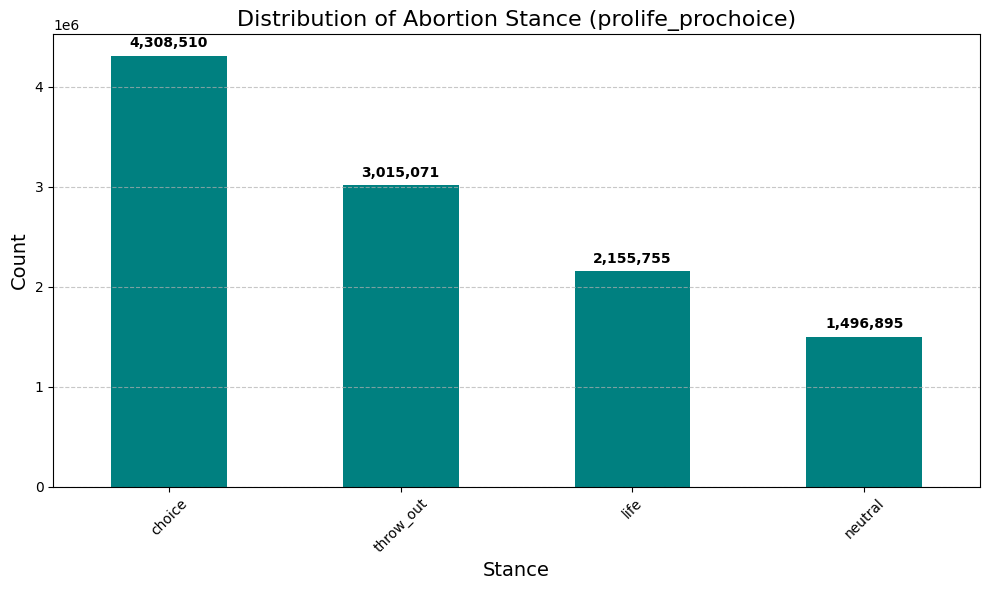

In [4]:
# Get unique values and their counts
stance_counts = df['prolife_prochoice'].value_counts()

# Display the number of unique values
unique_count = len(stance_counts)
print(f"Number of unique values in 'prolife_prochoice' column: {unique_count}")

# Display each unique value and its count
print("\nUnique values and their frequencies:")
for value, count in stance_counts.items():
    print(f"'{value}': {count:,} tweets ({count/len(df)*100:.2f}%)")

# Check for missing values
missing_count = df['prolife_prochoice'].isna().sum()
print(f"\nMissing values: {missing_count} ({missing_count/len(df)*100:.2f}%)")

# Create a visualization if there aren't too many unique values
if unique_count < 10:  
    plt.figure(figsize=(10, 6))
    stance_counts.plot(kind='bar', color='teal')
    plt.title('Distribution of Abortion Stance (prolife_prochoice)', fontsize=16)
    plt.xlabel('Stance', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on top of each bar
    for i, count in enumerate(stance_counts):
        plt.text(i, count + (stance_counts.max() * 0.02), f"{count:,}", 
                ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


## Comprehensive Analysis of Stance, Morality, and Moral Foundations by Year

=== STANCE DISTRIBUTION BY YEAR ===

Counts of each stance by year:
prolife_prochoice   choice    life  neutral  throw_out
year                                                  
2015.0              143163  334970   118597      18025
2016.0               92125  216881    73157       8959
2017.0              104068  257394    43404      11446
2018.0              104744  246298    32813      15223
2019.0              165101  338119    40702      17484
2020.0               84274  182622    20315      22322
2022.0             3584087  568083  1159897    2803861
2023.0               30795   11140     7687     117672

Percentage of each stance by year:
prolife_prochoice  choice   life  neutral  throw_out
year                                                
2015.0              23.29  54.49    19.29       2.93
2016.0              23.55  55.45    18.70       2.29
2017.0              25.00  61.83    10.43       2.75
2018.0              26.25  61.72     8.22       3.81
2019.0              29.41  6

<Figure size 1400x800 with 0 Axes>

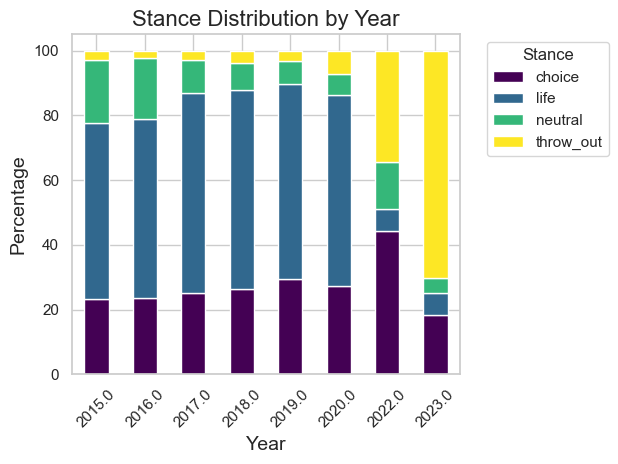


=== MORALITY DISTRIBUTION BY STANCE ===

Counts of moral vs. non-moral tweets by stance:
binary_morality      moral  non-moral
prolife_prochoice                    
choice             2705136    1603374
life               1165214     990541
neutral             165675    1331220
throw_out           832016    2183055

Percentage of moral vs. non-moral tweets by stance:
binary_morality    moral  non-moral
prolife_prochoice                  
choice             62.79      37.21
life               54.05      45.95
neutral            11.07      88.93
throw_out          27.60      72.40


<Figure size 1200x700 with 0 Axes>

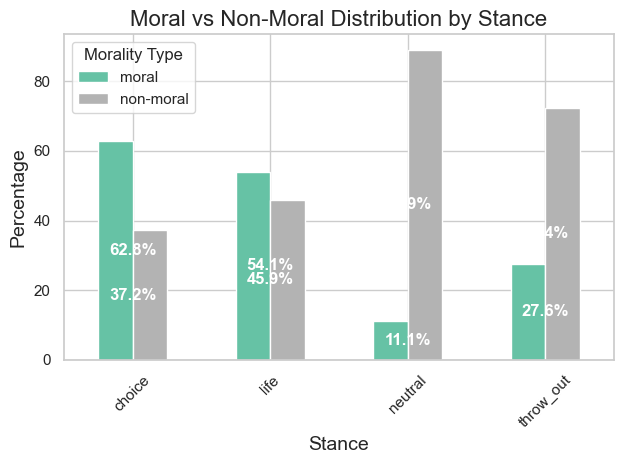


=== MORAL FOUNDATIONS BY STANCE ===

Counts of each moral foundation by stance:
              care  purity  loyalty  authority  fairness
choice     2080495  435688   778661     329426   2191213
life       1008099  476478   177186     179090    488974
neutral      98411   25505    72127       9626    117409
throw_out   742063  180658   109707     235287    396064

Percentage of each moral foundation by stance:
            care  purity  loyalty  authority  fairness
choice     76.91   16.11    28.78      12.18     81.00
life       86.52   40.89    15.21      15.37     41.96
neutral    59.40   15.39    43.54       5.81     70.87
throw_out  89.19   21.71    13.19      28.28     47.60


<Figure size 1400x1000 with 0 Axes>

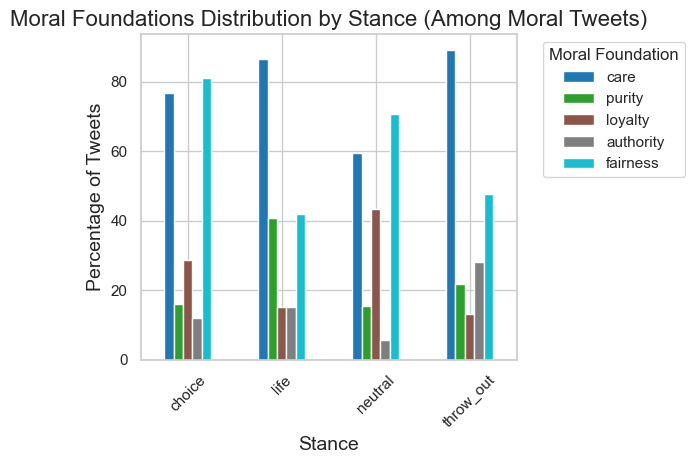

In [6]:
# Set up the visualization style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. Stance distribution by year
print("=== STANCE DISTRIBUTION BY YEAR ===")
stance_by_year = pd.crosstab(df['year'], df['prolife_prochoice'], normalize='index') * 100
stance_counts_by_year = pd.crosstab(df['year'], df['prolife_prochoice'])

# Display raw counts and percentages
print("\nCounts of each stance by year:")
print(stance_counts_by_year)
print("\nPercentage of each stance by year:")
print(stance_by_year.round(2))

# Visualize stance distribution by year
plt.figure(figsize=(14, 8))
stance_by_year.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Stance Distribution by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Stance', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('stance_by_year.png')
plt.show()

# 2. Morality distribution within each stance
print("\n=== MORALITY DISTRIBUTION BY STANCE ===")
morality_by_stance = pd.crosstab(df['prolife_prochoice'], df['binary_morality'], normalize='index') * 100
morality_counts_by_stance = pd.crosstab(df['prolife_prochoice'], df['binary_morality'])

print("\nCounts of moral vs. non-moral tweets by stance:")
print(morality_counts_by_stance)
print("\nPercentage of moral vs. non-moral tweets by stance:")
print(morality_by_stance.round(2))

# Visualize morality distribution by stance
plt.figure(figsize=(12, 7))
morality_by_stance.plot(kind='bar', colormap='Set2')
plt.title('Moral vs Non-Moral Distribution by Stance', fontsize=16)
plt.xlabel('Stance', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Morality Type')
for i, stance in enumerate(morality_by_stance.index):
    for col in morality_by_stance.columns:
        value = morality_by_stance.loc[stance, col]
        plt.text(i, value/2, f"{value:.1f}%", ha='center', va='center', 
                 color='white', fontweight='bold')
plt.tight_layout()
plt.savefig('morality_by_stance.png')
plt.show()

# 3. Moral foundation distribution for moral tweets within each stance
print("\n=== MORAL FOUNDATIONS BY STANCE ===")

# Filter only moral tweets
moral_tweets = df[df['binary_morality'] == 'moral']

# Create a function to analyze moral foundations
def analyze_moral_foundations():
    foundation_columns = ['care', 'purity', 'loyalty', 'authority', 'fairness']
    
    # Total counts by stance
    foundation_counts = {}
    foundation_percentages = {}
    
    for stance in moral_tweets['prolife_prochoice'].unique():
        stance_data = moral_tweets[moral_tweets['prolife_prochoice'] == stance]
        stance_total = len(stance_data)
        
        # Count each foundation
        counts = {}
        percentages = {}
        for foundation in foundation_columns:
            count = stance_data[foundation].sum()
            counts[foundation] = count
            percentages[foundation] = (count / stance_total) * 100
            
        foundation_counts[stance] = counts
        foundation_percentages[stance] = percentages
    
    # Convert to DataFrames
    counts_df = pd.DataFrame(foundation_counts).T
    percentages_df = pd.DataFrame(foundation_percentages).T
    
    return counts_df, percentages_df

foundation_counts, foundation_percentages = analyze_moral_foundations()

print("\nCounts of each moral foundation by stance:")
print(foundation_counts)
print("\nPercentage of each moral foundation by stance:")
print(foundation_percentages.round(2))

# Visualize moral foundations by stance
plt.figure(figsize=(14, 10))
foundation_percentages.plot(kind='bar', colormap='tab10')
plt.title('Moral Foundations Distribution by Stance (Among Moral Tweets)', fontsize=16)
plt.xlabel('Stance', fontsize=14)
plt.ylabel('Percentage of Tweets', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Moral Foundation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('moral_foundations_by_stance.png')
plt.show()


## Logistic Regression

Working with already loaded dataframe of shape: (10976231, 22)
Performing feature engineering...
Preparing features and target...
Splitting data into train and test sets...
Training set: 8,780,984 samples
Test set: 2,195,247 samples
Scaling features...
Training logistic regression model...
Loading pre-trained model...

Evaluating model on test set:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73   1333545
           1       0.58      0.53      0.56    861702

    accuracy                           0.67   2195247
   macro avg       0.65      0.64      0.64   2195247
weighted avg       0.66      0.67      0.66   2195247


Model Coefficients Analysis:
                       Feature  Coefficient  Odds Ratio
0              individualizing     0.635255    1.887504
3  individualizing_x_sentiment     0.100965    1.106238
1                      binding    -0.056941    0.944650
4          binding_x_sentiment    -0.086939    0.916733
2           

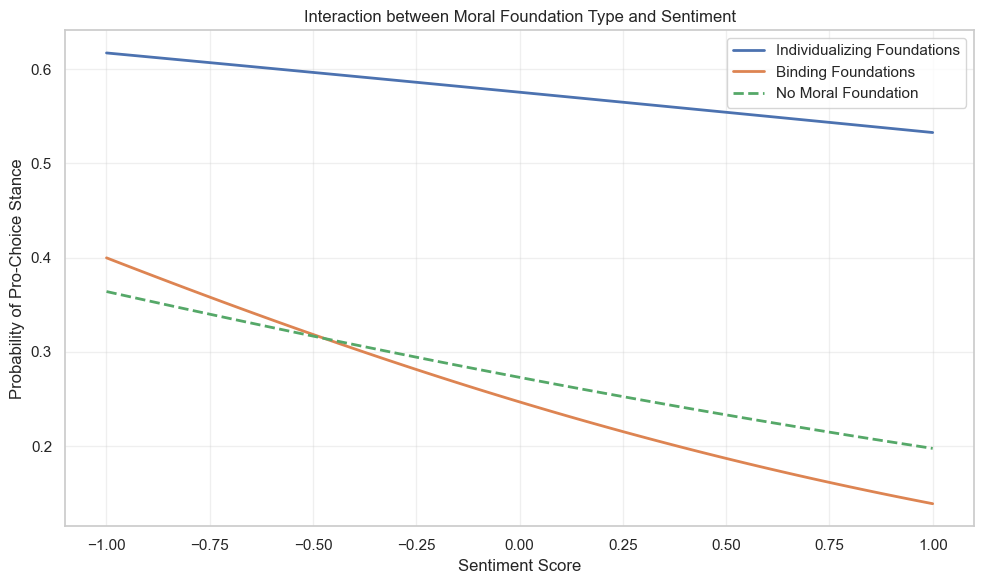

In [8]:

import warnings
warnings.filterwarnings('ignore')
print(f"Working with already loaded dataframe of shape: {df.shape}")

# 1. Setup directories for intermediate files
feature_dir = "processed_features"
os.makedirs(feature_dir, exist_ok=True)

# 2. Feature engineering on the loaded dataframe
print("Performing feature engineering...")
# Create foundation type features
df['individualizing'] = ((df['care'] == 1) | (df['fairness'] == 1)).astype(int)
df['binding'] = ((df['authority'] == 1) | (df['loyalty'] == 1) | (df['purity'] == 1)).astype(int)

# Create target variable
df['stance_binary'] = (df['prolife_prochoice'] == 'choice').astype(int)

# Create interaction terms
df['individualizing_x_sentiment'] = df['individualizing'] * df['sentiment_score']
df['binding_x_sentiment'] = df['binding'] * df['sentiment_score']

# 3. Prepare features and target
print("Preparing features and target...")
X = df[['individualizing', 'binding', 'sentiment_score', 
        'individualizing_x_sentiment', 'binding_x_sentiment']]
y = df['stance_binary']

# 4. Split data
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# 5. Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train model
print("Training logistic regression model...")
model_path = os.path.join(feature_dir, 'logistic_regression_model.joblib')
scaler_path = os.path.join(feature_dir, 'scaler.joblib')

if os.path.exists(model_path) and os.path.exists(scaler_path):
    print("Loading pre-trained model...")
    model = load(model_path)
else:
    print("Training new model...")
    model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    
    # Save the model and scaler
    dump(model, model_path)
    dump(scaler, scaler_path)
    print("Model and scaler saved.")

# 7. Evaluate model
print("\nEvaluating model on test set:")
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# 8. Analyze coefficients
print("\nModel Coefficients Analysis:")
feature_names = X.columns
coefficients = model.coef_[0]

# Create a DataFrame to display coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})
print(coef_df.sort_values('Coefficient', ascending=False))

# 9. Visualize coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient'))
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_regression_coefficients.png')
plt.close()

# 10. Visualize interaction effects
print("Generating interaction effects visualization...")
min_sentiment = df['sentiment_score'].min()
max_sentiment = df['sentiment_score'].max()
sentiment_range = np.linspace(min_sentiment, max_sentiment, 100)

# Function to predict probability for different foundation types
def predict_proba(sentiment, foundation_type):
    # Create a sample with the specified foundation type and sentiment
    if foundation_type == 'individualizing':
        sample = np.array([[1, 0, sentiment, sentiment, 0]])
    elif foundation_type == 'binding':
        sample = np.array([[0, 1, sentiment, 0, sentiment]])
    else:  # none
        sample = np.array([[0, 0, sentiment, 0, 0]])
    
    # Scale the sample
    sample_scaled = scaler.transform(sample)
    
    # Predict probability of pro-choice
    return model.predict_proba(sample_scaled)[0, 1]

# Calculate probabilities for different combinations
individualizing_probs = [predict_proba(s, 'individualizing') for s in sentiment_range]
binding_probs = [predict_proba(s, 'binding') for s in sentiment_range]
none_probs = [predict_proba(s, 'none') for s in sentiment_range]

# Plot interaction effects
plt.figure(figsize=(10, 6))
plt.plot(sentiment_range, individualizing_probs, label='Individualizing Foundations', linewidth=2)
plt.plot(sentiment_range, binding_probs, label='Binding Foundations', linewidth=2)
plt.plot(sentiment_range, none_probs, label='No Moral Foundation', linewidth=2, linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Probability of Pro-Choice Stance')
plt.title('Interaction between Moral Foundation Type and Sentiment')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('interaction_effects.png')
print("Analysis complete. Visualization files saved.")


## Random Forest Analysis 

In [9]:
# Assuming X_train_scaled, X_test_scaled, y_train, y_test are already defined
print("Training Random Forest model...")
start_time = time.time()

# Create directory for models if it doesn't exist
feature_dir = "processed_features"
os.makedirs(feature_dir, exist_ok=True)

# Check if model already exists
rf_model_path = os.path.join(feature_dir, 'random_forest_model.joblib')

if os.path.exists(rf_model_path):
    print("Loading pre-trained Random Forest model...")
    rf_model = load(rf_model_path)
else:
    print("Training new Random Forest model...")
    # Use fewer trees for faster training while still getting good performance
    rf_model = RandomForestClassifier(
        n_estimators=100,  # Fewer trees for computational efficiency
        max_depth=10,      # Limit depth to prevent overfitting
        min_samples_split=50,
        min_samples_leaf=20,
        max_features='sqrt',
        n_jobs=-1,         # Use all cores
        random_state=42
    )
    rf_model.fit(X_train, y_train)  # Note: Random Forests don't require scaling
    
    # Save the model
    dump(rf_model, rf_model_path)

# Calculate training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate model
print("\nEvaluating Random Forest model on test set:")
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# Compare with logistic regression
print("\nComparison with Logistic Regression:")
print("Random Forest accuracy:", rf_model.score(X_test, y_test))
print("Logistic Regression accuracy:", model.score(X_test_scaled, y_test))

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(feature_importances)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('random_forest_importance.png')
plt.close()

# Partial dependence plots for top features
from sklearn.inspection import PartialDependenceDisplay

print("Generating partial dependence plots...")
features_to_plot = list(feature_importances['Feature'].head(3).values)
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf_model, X_test, features_to_plot, ax=ax, kind='both'
)
plt.tight_layout()
plt.savefig('partial_dependence_plots.png')
plt.close()

# Comparison of predictions between models
predictions_comparison = pd.DataFrame({
    'True Stance': y_test,
    'Logistic Regression': model.predict(X_test_scaled),
    'Random Forest': rf_model.predict(X_test)
})

# Calculate agreement between models
agreement = (predictions_comparison['Logistic Regression'] == 
             predictions_comparison['Random Forest']).mean()
print(f"\nAgreement between models: {agreement:.2%}")

# Where do models disagree?
disagreement = predictions_comparison[
    predictions_comparison['Logistic Regression'] != 
    predictions_comparison['Random Forest']
]
print(f"Number of cases where models disagree: {len(disagreement):,}")

# How often is each model correct when they disagree?
lr_correct_when_disagree = (disagreement['Logistic Regression'] == 
                           disagreement['True Stance']).mean()
rf_correct_when_disagree = (disagreement['Random Forest'] == 
                           disagreement['True Stance']).mean()

print(f"When models disagree:")
print(f"  Logistic Regression correct: {lr_correct_when_disagree:.2%}")
print(f"  Random Forest correct: {rf_correct_when_disagree:.2%}")


Training Random Forest model...
Training new Random Forest model...
Training completed in 212.15 seconds

Evaluating Random Forest model on test set:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75   1333545
           1       0.61      0.57      0.59    861702

    accuracy                           0.69   2195247
   macro avg       0.67      0.67      0.67   2195247
weighted avg       0.69      0.69      0.69   2195247


Comparison with Logistic Regression:
Random Forest accuracy: 0.6888054054965114
Logistic Regression accuracy: 0.6664188585612462

Random Forest Feature Importance:
                       Feature  Importance
0              individualizing    0.419866
3  individualizing_x_sentiment    0.265678
2              sentiment_score    0.222027
4          binding_x_sentiment    0.058822
1                      binding    0.033607
Generating partial dependence plots...

Agreement between models: 90.20%
Number of cases where model

## Partial Dependance Plot 

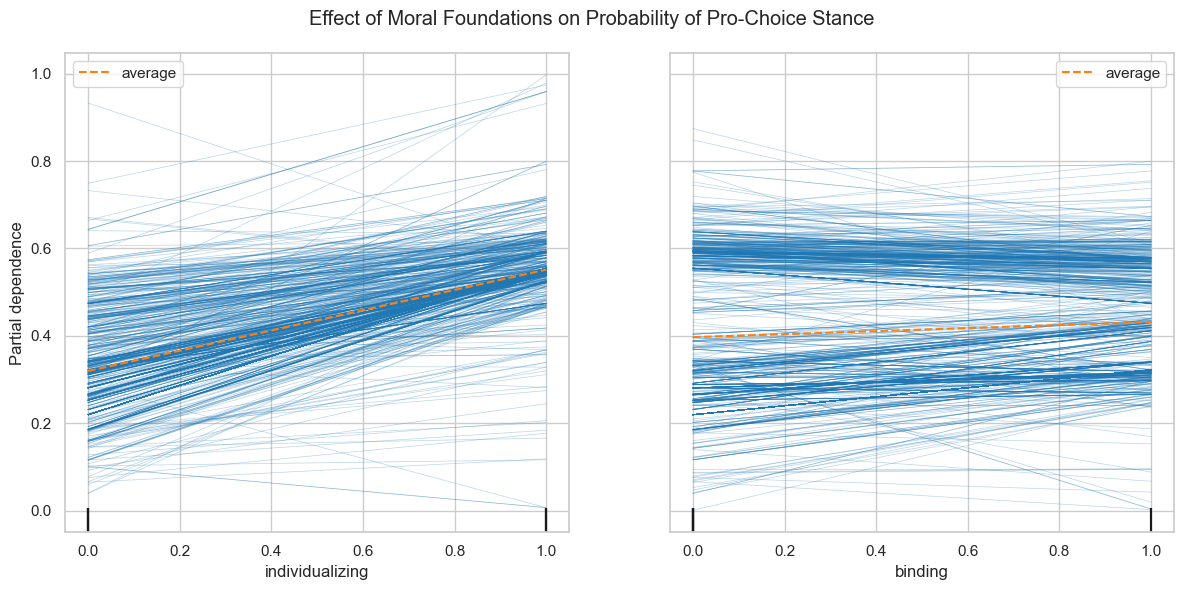

In [10]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Create partial dependence plots for individualizing and binding foundations
features_to_plot = ['individualizing', 'binding']
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the partial dependence - higher values indicate higher probability of pro-choice
pdp = PartialDependenceDisplay.from_estimator(
    rf_model,                # the trained Random Forest model
    X_test,                  # the test dataset
    features_to_plot,        # Features to analyze
    kind='both',             # Show both average and individual effects
    target=1,                # Target is pro-choice (1)
    ax=ax
)

plt.suptitle('Effect of Moral Foundations on Probability of Pro-Choice Stance')
plt.tight_layout()
plt.savefig('moral_foundations_pdp.png')
plt.show()


## Visualization 1: Interactions Plot based on regression
Purpose: Demonstrate how moral foundations and sentiment predict stance

Description: Interaction visualization showing how sentiment modulates moral foundation effects

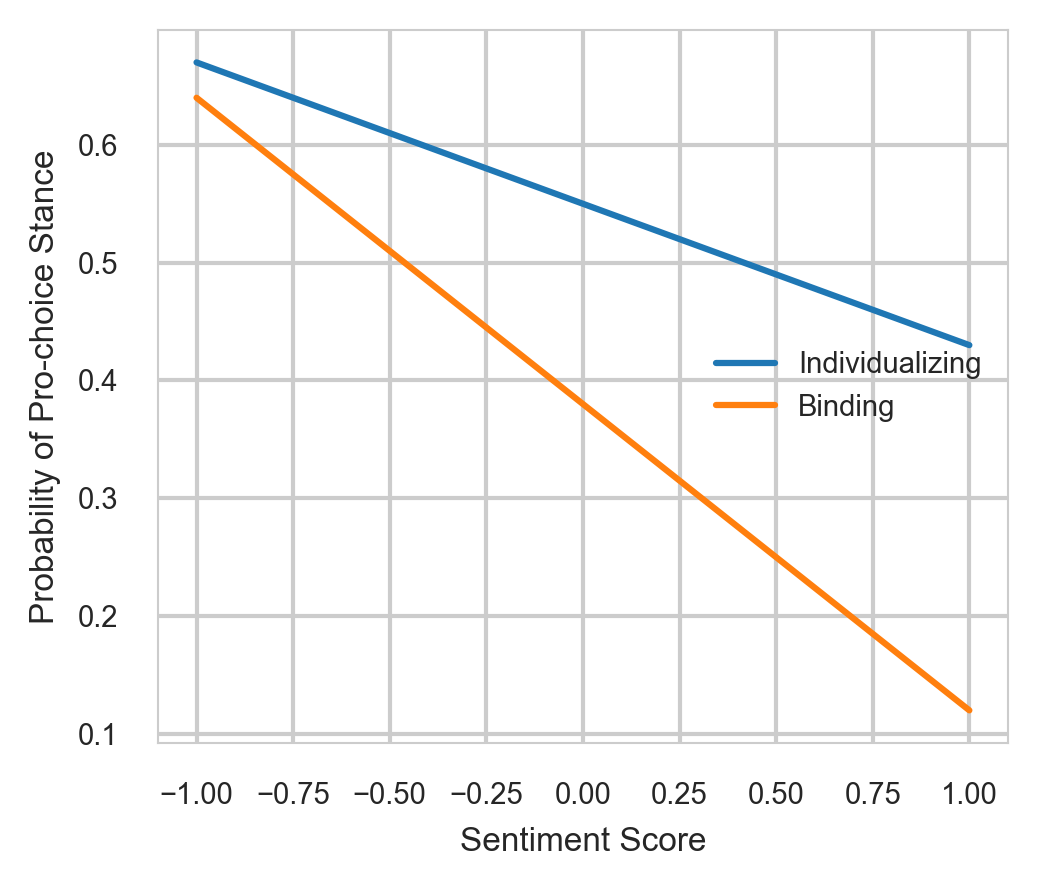

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Set Nature-style aesthetics
plt.rcParams.update({
    'font.sans-serif': 'Arial',
    'font.size': 8,
    'axes.linewidth': 0.5,
    'axes.labelsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'legend.frameon': False
})

# Create figure
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)

# Generate mock data
sentiment = np.linspace(-1, 1, 100)
prob_ind_1 = 0.55 - 0.12 * sentiment   # Yes individualizing
prob_bind_1 = 0.38 - 0.26 * sentiment  # Yes binding

# Plot interaction lines
ax.plot(sentiment, prob_ind_1, '-', color='#1f77b4', label='Individualizing')
ax.plot(sentiment, prob_bind_1, '-', color='#ff7f0e', label='Binding')

# Axis labels and formatting
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Probability of Pro-choice Stance')
ax.legend(loc='center right')

# Save to file
plt.tight_layout()
plt.savefig('/Users/yaldadaryani/Desktop/plots/panel_c_interaction.png', dpi=600, bbox_inches='tight')
plt.show()


## Effect of Moral Foundations on Pro-Choice Stance based on regression

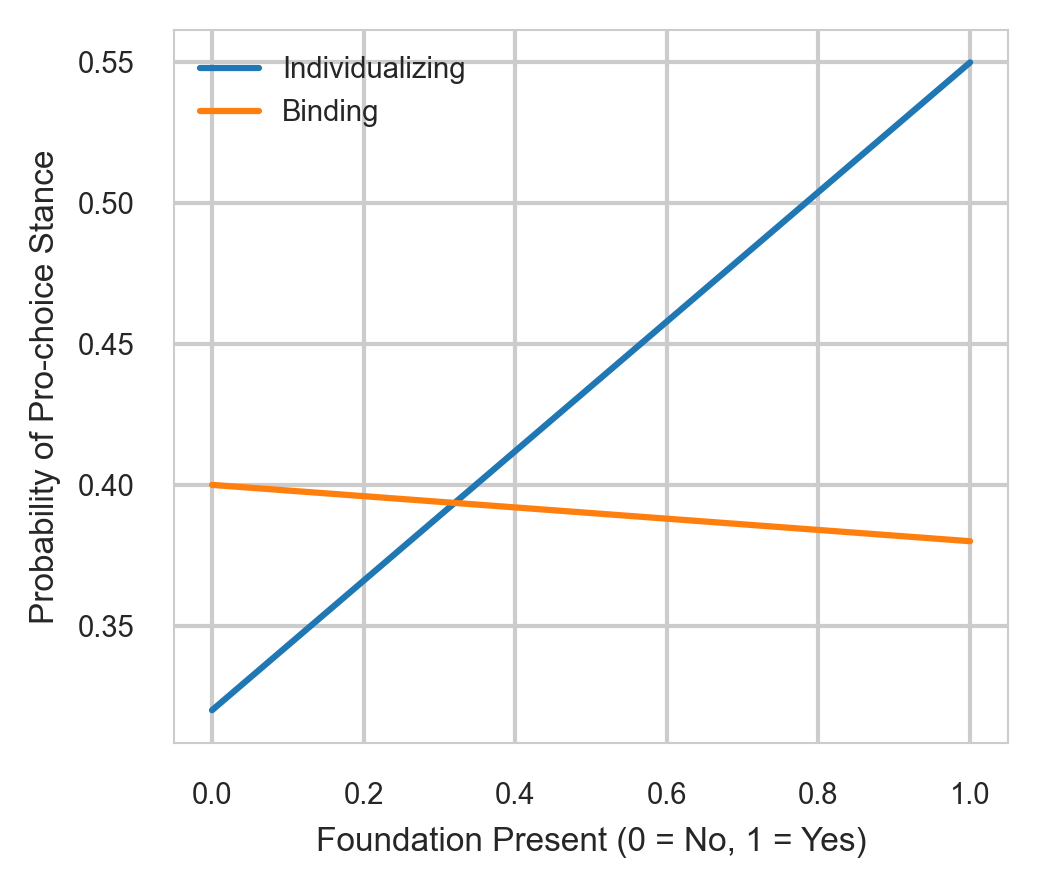

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Set Nature-style aesthetics
plt.rcParams.update({
    'font.sans-serif': 'Arial',
    'font.size': 8,
    'axes.linewidth': 0.5,
    'axes.labelsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'legend.frameon': False
})

# Create figure
fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)

# Simulated data (replace with actual model results if available)
x = np.linspace(0, 1, 100)
y_ind = 0.32 + 0.23 * x  # Individualizing effect
y_bind = 0.40 - 0.02 * x  # Binding effect

# Plot lines
ax.plot(x, y_ind, label='Individualizing', color='#1f77b4')
ax.plot(x, y_bind, label='Binding', color='#ff7f0e')

# Labels and title
ax.set_xlabel('Foundation Present (0 = No, 1 = Yes)')
ax.set_ylabel('Probability of Pro-choice Stance')
ax.legend()

# Save to file
plt.tight_layout()
plt.savefig('/Users/yaldadaryani/Desktop/plots/panel_b_foundation_effects.png', dpi=600, bbox_inches='tight')
plt.show()


## Model Performance Comparison
Purpose: Demonstrate robustness of findings across methodologies
Panel A: Side-by-side precision-recall comparison
Panel B: Confusion matrices for both models
Panel C: Agreement analysis between models

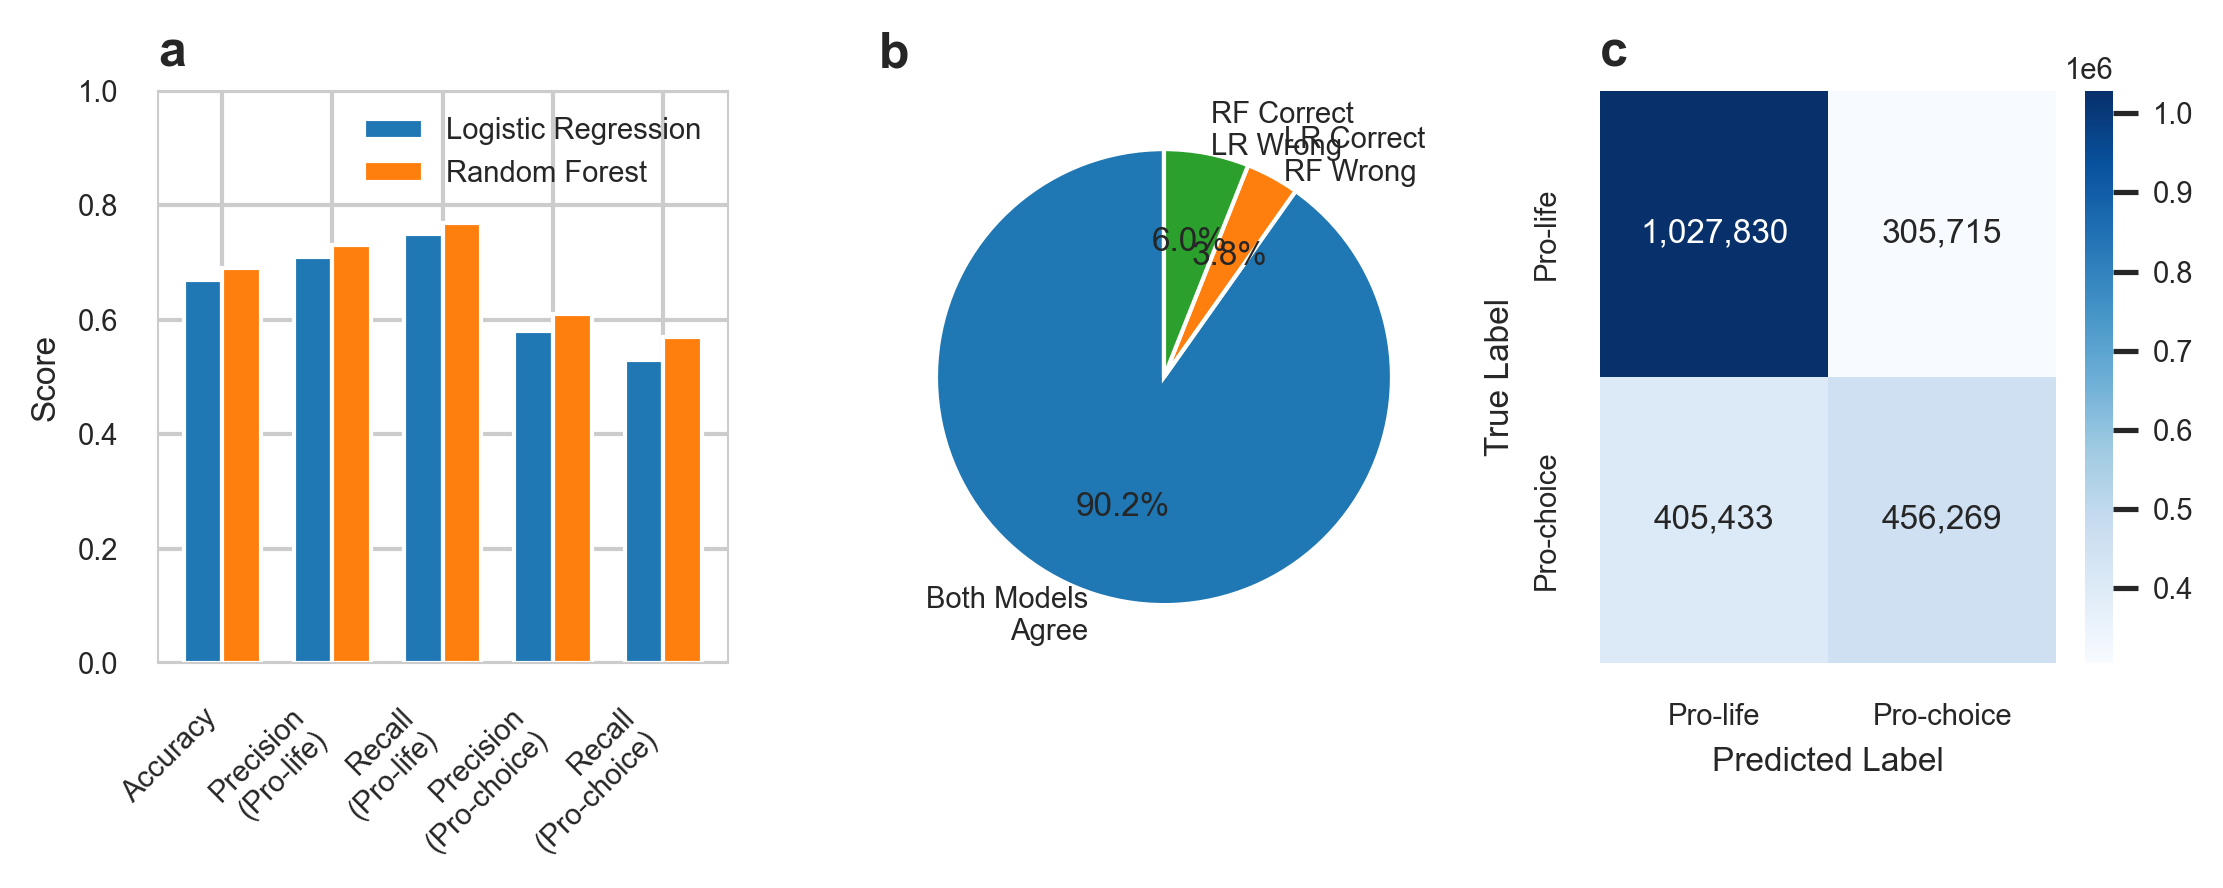

In [17]:
# Create figure with 3 panels
fig = plt.figure(figsize=(7.5, 3), dpi=300)

# Panel A: Precision-Recall Comparison
ax1 = fig.add_subplot(131)
metrics = ['Accuracy', 'Precision\n(Pro-life)', 'Recall\n(Pro-life)', 
           'Precision\n(Pro-choice)', 'Recall\n(Pro-choice)']
lr_scores = [0.67, 0.71, 0.75, 0.58, 0.53]
rf_scores = [0.69, 0.73, 0.77, 0.61, 0.57]

x = np.arange(len(metrics))
width = 0.35
ax1.bar(x - width/2, lr_scores, width, label='Logistic Regression', color='#1f77b4')
ax1.bar(x + width/2, rf_scores, width, label='Random Forest', color='#ff7f0e')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper right', frameon=False)
ax1.set_title('a', loc='left', fontweight='bold')

# Panel B: Model Agreement Analysis
ax2 = fig.add_subplot(132)
agreement = 0.902
disagreement = 0.098
lr_correct = 0.3858
rf_correct = 0.6142

agreement_data = [agreement, disagreement * lr_correct, disagreement * rf_correct]
labels = ['Both Models\nAgree', 'LR Correct\nRF Wrong', 'RF Correct\nLR Wrong']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax2.pie(agreement_data, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, wedgeprops={'edgecolor': 'w'})
ax2.set_title('b', loc='left', fontweight='bold')

# Panel C: Confusion Matrix Comparison (use actual data if available)
ax3 = fig.add_subplot(133)
# This would use your actual confusion matrices
# For illustration, we'll create mockups
rf_cm = np.array([[1027830, 305715], [405433, 456269]])  # Random Forest
heatmap = sns.heatmap(rf_cm, annot=True, fmt=',.0f', cmap='Blues', 
                    xticklabels=['Pro-life', 'Pro-choice'],
                    yticklabels=['Pro-life', 'Pro-choice'], ax=ax3)
ax3.set_title('c', loc='left', fontweight='bold')
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('True Label')

plt.tight_layout()
plt.savefig('figure2_model_performance.png', dpi=600, bbox_inches='tight')
plt.show()
